In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from joblib import dump, load


In [2]:
#importing the Dataset
Dataset = pd.read_csv('TSLA.csv')
df= Dataset.copy()
print(df.head())
print(df.info)
print(df.describe)
print(df.isnull().sum())

         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
<bound method DataFrame.info of             Date        Open        High         Low       Close   Adj Close  \
0     2010-06-29   19.000000   25.000000   17.540001   23.889999   23.889999   
1     2010-06-30   25.790001   30.420000   23.299999   23.830000   23.830000   
2     2010-07-01   25.000000   25.920000   20.270000   21.959999   21.959999   
3     2010-07-02   23.000000   23.100000   18.709999   19.200001   19.200001   
4     2010-07-06   20.000000   20.000000   15.830000   16.110001   16.110001   
...          ...         ...         .

In [3]:
# Once the Dataset is imported, we perform a basic EDA to understand the relationship of the features with its target variable
# Here we set the Date column as index so we can calculate the closing price with respect to the date
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


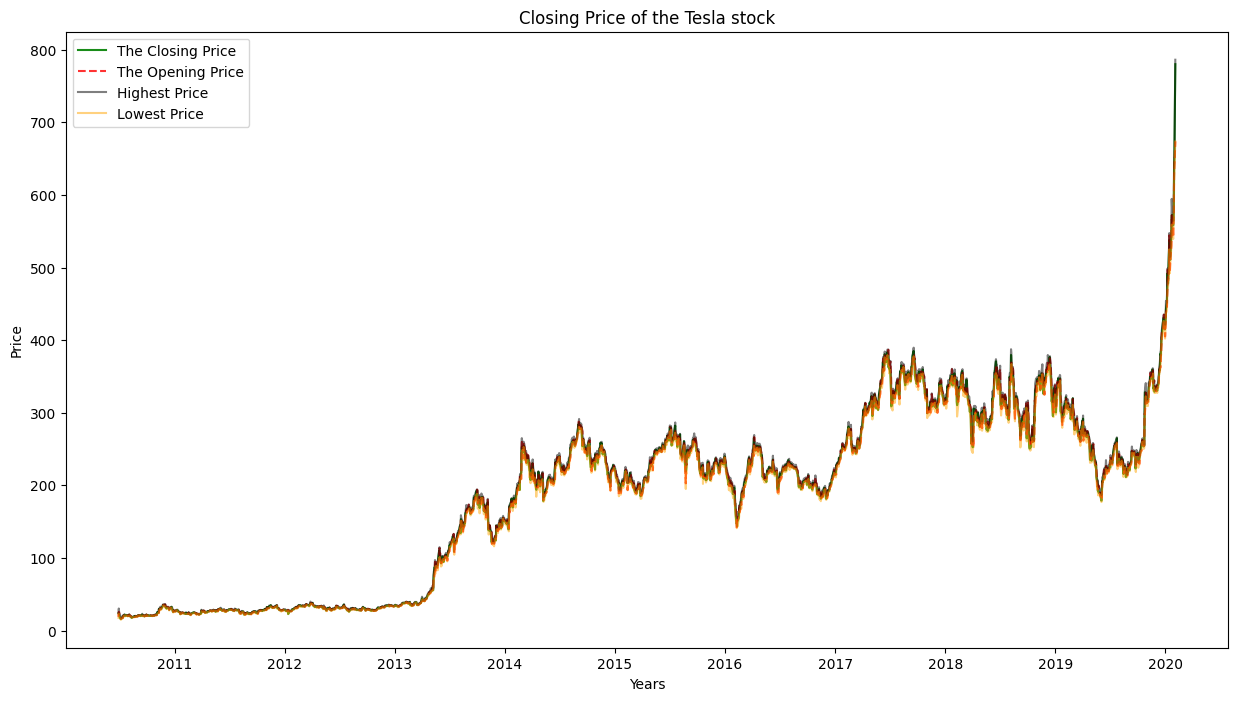

In [4]:
plt.figure(figsize=(15,8))
plt.plot(df['Close'], color = 'green', alpha = 0.9, label= 'The Closing Price')
plt.plot(df['Open'], color = 'red', linestyle = '--', alpha = 0.8, label = 'The Opening Price')
plt.plot(df['High'], color= 'black', label='Highest Price', alpha = 0.5)
plt.plot(df['Low'], color= 'orange', label='Lowest Price', alpha = 0.5)
plt.title('Closing Price of the Tesla stock')
plt.xlabel('Years')
plt.ylabel('Price')
plt.legend();

#### The graph shows all the lines almost super imposing on each other. This might suggest that all the features might be  Multicollinear
#### We can confirm this Multicollinearity through a correlation heatmap

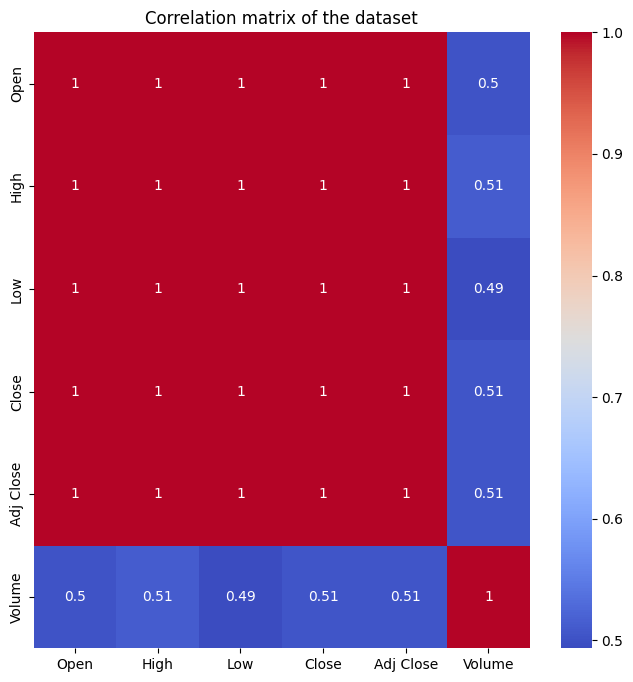

In [5]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation matrix of the dataset');

#### The Above Heatmap confirms severe multicollinearity. The next step could be to measure the multicollinearity through VIF (Variance Inflation Factor)

In [6]:
# Calculating the VIF of each feature to measure the multicollinearity
x= df.drop('Close', axis = 1)
x= sm.add_constant(x)
VIF = pd.DataFrame()
VIF['Features'] = x.columns
VIF['VIF_values'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(VIF)

    Features   VIF_values
0      const     3.652775
1       Open  2936.358404
2       High  4488.789091
3        Low  3869.964349
4  Adj Close  3445.595689
5     Volume     2.298497


##### From the VIF values we come to know that the columns apart from 'volume' should not be considered for the Regression model because of its high VIF value
##### To tackle this problem of severe multicollinearity we will use Ridge Regression instead of Linear Regression as Ridge Regression helps to stabilize the regression coefficients and prevent them from becoming excessively large due to highly correlated predictor

In [7]:
# We will drop the column 'Adj close' as it is very similar to the target variable
X= df.drop(columns=['Close', 'Adj Close'])
y = df['Close']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 101)

### Performing Ridge Regression

In [9]:
model = Ridge(alpha = 5)
model.fit(X_train, y_train)

Ridge(alpha=5)

In [10]:
pred = model.predict(X_test)

##### Calculating the Error Metrics. These Values will determine how well the model is performing

In [11]:
print('MAE =', (mean_absolute_error(y_test, pred)))
print('MSE =', (mean_squared_error(y_test, pred)))
print('RSME =',(np.sqrt(mean_squared_error(y_test, pred))))
print('R2 =', (r2_score(y_test, pred)))


MAE = 1.3498829773335532
MSE = 4.249496606185495
RSME = 2.061430718259892
R2 = 0.9996968005238132


In [12]:
#Perform cross-validation to check for overfitting
# Performing a 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = np.mean(-cv_scores)
cv_std = np.std(-cv_scores)

print(f'Cross-Validation Mean Squared Error (MSE): {cv_mean}')
print(f'Cross-Validation Standard Deviation (MSE): {cv_std}')

Cross-Validation Mean Squared Error (MSE): 4.216836556756696
Cross-Validation Standard Deviation (MSE): 3.162857403807181


In [13]:
dump(model, 'Tesla_Stock_Prediction_model')

['Tesla_Stock_Prediction_model']

In [14]:
Load_model = load('Tesla_Stock_Prediction_model')
Load_model

Ridge(alpha=5)

In [24]:
# checking the predictions 
pred1 = model.predict(X_test)[350]

In [25]:
pred1

320.3850002154102

In [23]:
y_test.iloc[350]

317.25